<a href="https://colab.research.google.com/github/yxmauw/cxr-multilabel-clf/blob/main/enet-kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np 
import pandas as pd 

In [ ]:
train_df = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train.csv')
display(len(train_df))
display(train_df.head(3))
train_annot_df = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv')
display(len(train_annot_df))
display(train_annot_df.head(3))

30083

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5


17999

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."


In [ ]:
# value counts
train_df.drop(columns=['StudyInstanceUID','PatientID']).agg(['sum'])
# unbalanced dataset

,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
sum,79,1138,7240,279,529,2748,4797,3195,8460,21324,830


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

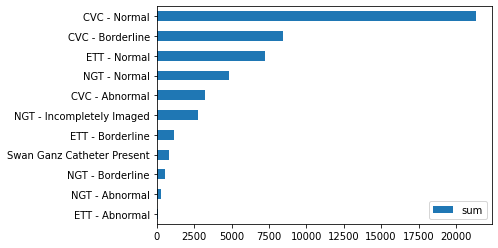

In [ ]:
# value counts
train_df.drop(columns=['StudyInstanceUID','PatientID']).agg(['sum']).T.sort_values(by='sum').plot(kind='barh')
plt.legend(loc='lower right');

In [ ]:
len(train_df.drop(columns=['StudyInstanceUID','PatientID']).agg(['sum']).T)
# num of classes

11

In [ ]:
import torch
import cv2
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['StudyInstanceUID']
        self.all_labels = np.array(self.csv.drop(['StudyInstanceUID', 'PatientID'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train == True:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"../input/ranzcr-clip-catheter-line-classification/train/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

In [ ]:
import torchvision
torchvision.__version__

'0.12.0'

In [ ]:
print(dir(torchvision.models))

['AlexNet', 'ConvNeXt', 'DenseNet', 'EfficientNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3', 'InceptionOutputs', 'MNASNet', 'MobileNetV2', 'MobileNetV3', 'RegNet', 'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', 'VisionTransformer', '_GoogLeNetOutputs', '_InceptionOutputs', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'alexnet', 'convnext', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection', 'efficientnet', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'feature_extraction', 'googlenet', 'inception', 'inception_v3', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'mobilenetv2', 'mobilenetv3', 'optical_fl

In [ ]:
from torchvision import models 
import torch.nn as nn
def model(pretrained, requires_grad):
    model = models.efficientnet_b7(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    # we have 11 classes in total
    model.classifier[1] = nn.Linear(in_features=2560, out_features=11)
    return model

In [ ]:
from tqdm import tqdm
from torchmetrics import Accuracy, AUROC, F1Score, Precision, Recall
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    # instantiate metrics
    acc = Accuracy()
    auc = AUROC()
    f1_score = F1Score()
    precision = Precision()
    recall = Recall()
    preds = []
    labels = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        labels.append(target.cpu().numpy().argmax(axis=1))
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        preds.append(outputs.detach().cpu().numpy().argmax(axis=1))
        
    train_loss = train_running_loss / counter
    preds = torch.tensor(np.concatenate(preds))
    labels = torch.tensor(np.concatenate(labels))
    train_acc = acc(preds, labels).item()
    
    return train_loss, train_acc

In [ ]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    # instantiate metrics
    acc = Accuracy()
    auc = AUROC()
    f1_score = F1Score()
    precision = Precision()
    recall = Recall()
    preds = []
    labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            labels.append(target.cpu().numpy().argmax(axis=1))
            # make predictions
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target)
            val_running_loss += loss.item()
            preds.append(outputs.detach().cpu().numpy().argmax(axis=1))
        
        val_loss = val_running_loss / counter
        preds = torch.tensor(np.concatenate(preds))
        labels = torch.tensor(np.concatenate(labels))
        val_acc = acc(preds, labels).item()
        return val_loss, val_acc

In [ ]:
import torch.optim as optim
import matplotlib
from torch.utils.data import DataLoader
matplotlib.style.use('ggplot')
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#intialize the model
from torch.optim.lr_scheduler import ReduceLROnPlateau

ENet_model = model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.0001
epochs = 30
batch_size = 32
optimizer = optim.Adam(ENet_model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min')
criterion = nn.BCELoss()

In [ ]:
train_data = ImageDataset(
    train_df, train=True, test=False
)
# validation dataset
valid_data = ImageDataset(
    train_df, train=False, test=False
)
# train data loader
train_loader = DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

Number of training images: 25570
Number of validation images: 4513


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
# start the training and validation
train_loss = []
valid_loss = []
train_acc = []
val_acc = []
early_stopper = EarlyStopper(patience=5, min_delta=0.001)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(
        ENet_model, train_loader, optimizer, criterion, train_data, device
    )
    valid_epoch_loss, val_epoch_acc = validate(
        ENet_model, valid_loader, criterion, valid_data, device
    )
    if early_stopper.early_stop(valid_epoch_loss):             
        break
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_acc.append(val_epoch_acc)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')
    print(f'Train accuracy: {train_epoch_acc:.4f}')
    print(f'Val accuracy: {val_epoch_acc:.4f}')

/opt/conda/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Epoch 1 of 30
Training


  0%|          | 0/799 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
800it [48:36,  3.65s/it]                         


Validating


141it [08:23,  3.57s/it]                         


Train Loss: 0.4688
Val Loss: 0.5190
Train accuracy: 0.3987
Val accuracy: 0.4033
Epoch 2 of 30
Training


800it [45:57,  3.45s/it]                         


Validating


141it [07:49,  3.33s/it]                         


Train Loss: 0.3776
Val Loss: 0.3924
Train accuracy: 0.4472
Val accuracy: 0.4706
Epoch 3 of 30
Training


800it [46:11,  3.46s/it]                         


Validating


141it [07:51,  3.35s/it]                         


Train Loss: 0.3433
Val Loss: 0.3581
Train accuracy: 0.4567
Val accuracy: 0.4801
Epoch 4 of 30
Training


800it [45:33,  3.42s/it]                         


Validating


141it [07:48,  3.32s/it]                         


Train Loss: 0.3224
Val Loss: 0.3392
Train accuracy: 0.4632
Val accuracy: 0.4832
Epoch 5 of 30
Training


800it [45:28,  3.41s/it]                         


Validating


141it [07:48,  3.32s/it]                         


Train Loss: 0.3092
Val Loss: 0.3225
Train accuracy: 0.4662
Val accuracy: 0.4843
Epoch 6 of 30
Training


800it [45:10,  3.39s/it]                         


Validating


141it [07:45,  3.30s/it]                         


Train Loss: 0.3027
Val Loss: 0.3136
Train accuracy: 0.4667
Val accuracy: 0.4861
Epoch 7 of 30
Training


800it [45:19,  3.40s/it]                         


Validating


141it [07:49,  3.33s/it]                         


Train Loss: 0.2951
Val Loss: 0.3053
Train accuracy: 0.4677
Val accuracy: 0.4861
Epoch 8 of 30
Training


800it [45:25,  3.41s/it]                         


Validating


141it [07:47,  3.32s/it]                         


Train Loss: 0.2905
Val Loss: 0.2986
Train accuracy: 0.4689
Val accuracy: 0.4852
Epoch 9 of 30
Training


800it [45:28,  3.41s/it]                         


Validating


141it [07:49,  3.33s/it]                         


Train Loss: 0.2878
Val Loss: 0.2941
Train accuracy: 0.4700
Val accuracy: 0.4817
Epoch 10 of 30
Training


800it [45:26,  3.41s/it]                         


Validating


141it [07:48,  3.32s/it]                         


Train Loss: 0.2844
Val Loss: 0.2889
Train accuracy: 0.4689
Val accuracy: 0.4801
Epoch 11 of 30
Training


800it [45:33,  3.42s/it]                         


Validating


141it [07:46,  3.31s/it]                         


Train Loss: 0.2825
Val Loss: 0.2847
Train accuracy: 0.4689
Val accuracy: 0.4797
Epoch 12 of 30
Training


 69%|██████▊   | 548/799 [31:11<14:19,  3.42s/it]